In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import os
from typing import Tuple, Dict, List
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
# https://medium.com/@karuneshu21/resnet-paper-walkthrough-b7f3bdba55f0
# https://arxiv.org/pdf/1512.03385.pdf
# https://medium.com/@karuneshu21/how-to-resnet-in-pytorch-9acb01f36cf5
torch.autograd.set_detect_anomaly(True)

c:\Users\Jakub Machura\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Data():
    def __init__(self) -> None:
        from torchvision.transforms import ToTensor
        import numpy as np
        from torch.utils.data import Subset
        self.train_data_full =datasets.Food101(
            root='D:\PytorchData\data',
            split="train",
            download=False,
            transform=transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
                ]
            )
        )
        indices = list(range(len(self.train_data_full)))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * 0.002)
        self.train_data = Subset(self.train_data_full, indices[:split_idx])

        self.test_data_full=datasets.Food101(
            root='D:\PytorchData\data',
            split="test",
            download=False,
            transform=transforms.Compose(
                [
                    transforms.Resize((224,224)),
                    transforms.ToTensor()
                ]
            )
        )
        
        indices = list(range(len(self.test_data_full)))
        np.random.shuffle(indices)
        split_idx = int(len(indices) * 0.002)
        self.test_data = Subset(self.test_data_full, indices[:split_idx])


        self.classes=self.train_data_full.classes
        self.ToDataloader()
    def ToDataloader(self):
        BATCH_SIZE=32
        self.train_dataloader=DataLoader(self.train_data,batch_size=BATCH_SIZE,shuffle=True)
        self.test_dataloader=DataLoader(self.test_data,batch_size=BATCH_SIZE,shuffle=False)
        

In [4]:
def train_step(model,optimizer,loss_fn,data:Data):
    
    model.train()
    train_loss,train_acc=0,0

    for batch, (X,y) in enumerate(data.train_dataloader):
        y_logits=model(X)

        loss=loss_fn(y_logits,y)
        train_loss+=loss.item()


        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class=y_logits.argmax(dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_logits)

    train_loss=train_loss/len(data.train_dataloader)
    train_acc=train_acc/len(data.train_dataloader)
    return train_loss,train_acc

def test_step(model,loss_fn,data:Data):
    model.eval()
    test_loss,test_acc=0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):
            y_logits=model(X)
            
            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            y_pred_class=y_logits.argmax(dim=1)
            test_acc+=(y_pred_class==y).sum().item()/len(y_logits)

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)

    return test_loss,test_acc

def Totrain(model,data:Data,optimizer,loss_fn,epochs:int):
    results={"train_loss":[],
             "train_acc" :[],
             "test_loss":[],
             "test_acc": []
             }
    
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,optimizer,loss_fn,data)
        test_loss,test_acc=test_step(model,loss_fn,data)

                
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [5]:
def plot_loss_curves(results: Dict[str, List[float]]):
    import matplotlib.pyplot as plt
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.ylim([0,20])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [6]:
# data=CustomDataTest()

# net=ResNet(3,len(data.train_data.classes))
# net_optimizer=torch.optim.SGD(net.parameters(),lr=0.1)
# net_loss_fn=nn.CrossEntropyLoss()
# res=Totrain(net,data,net_optimizer,net_loss_fn,2)


# x=torch.randn(32,3,224,224)
# print(f"out shape {y.shape}")



RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 512, 7, 7]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!


In [7]:
class SimpleResNetblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,identity_downsample=None) -> None:
        super(SimpleResNetblock,self).__init__()

        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=stride)
        self.bn1=nn.BatchNorm2d(out_channels)
       
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(out_channels)
       
        self.relu=nn.ReLU()

        self.identity_downsample=identity_downsample
    
    def forward(self,x):
        identity=x
        # print(f"identity shape x{identity.shape}")
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)

        x=self.conv2(x)
        x=self.bn2(x)

        if self.identity_downsample != None:
            identity=self.identity_downsample(identity)
            # print(f"identity shape after {identity.shape}")
            # print(f"x shape {x.shape}")

        x+=identity
        x=self.relu(x)
        # print(f"x shape {x.shape}")

        return x


In [8]:
class ResNet18(nn.Module):
    def __init__(self,block:SimpleResNetblock,img_channels,num_classes,block_num:list) -> None:
        super(ResNet18,self).__init__()
        
        self.in_channels=64

        self.conv1=nn.Conv2d(img_channels,64,kernel_size=7,stride=2,padding=3)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer2=self._make_layer(block,block_num[0],64,1)
        self.layer3=self._make_layer(block,block_num[1],128,2)
        self.layer4=self._make_layer(block,block_num[2],256,2)
        self.layer5=self._make_layer(block,block_num[3],512,2)

        

        self.avg=nn.AvgPool2d((1,1))
        self.fc=nn.Linear(512*7*7,num_classes)


    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)

        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)

        
        x=self.avg(x)
        # print(f"shape after avg {x.shape}")
        x=x.reshape(x.shape[0],-1)
        # print(f"shape after reshape {x.shape}")
        x=self.fc(x)
        # print(f"output shape {x.shape}")
        
        return x
    
    def _make_layer(self,block,num_blocks,out_channels,stride):
        identity_downsample=None
        layers=[]
        if stride!=1:
            identity_downsample=nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels,1,stride,padding=0),
                nn.BatchNorm2d(out_channels)
            )
        layers.append(block(self.in_channels,out_channels=out_channels,stride=stride,identity_downsample=identity_downsample))
        self.in_channels=out_channels

        for i in range(num_blocks-1):
            layers.append(block(self.in_channels,out_channels=out_channels))

        return nn.Sequential(*layers)

len train_dataloader 160
len test_dataloader 64
in shape torch.Size([2, 3, 224, 224])
out shape torch.Size([2, 101])


 25%|██▌       | 1/4 [00:13<00:39, 13.22s/it]

Epoch: 1 | train_loss: 98.7618 | train_acc: 0.0000 | test_loss: 267286159360.0000 | test_acc: 0.0000


 50%|█████     | 2/4 [00:23<00:23, 11.51s/it]

Epoch: 2 | train_loss: 52.3707 | train_acc: 0.0212 | test_loss: 11830195.0000 | test_acc: 0.0000


 75%|███████▌  | 3/4 [00:35<00:11, 11.79s/it]

Epoch: 3 | train_loss: 21.3043 | train_acc: 0.0125 | test_loss: 26731.7217 | test_acc: 0.0278


100%|██████████| 4/4 [00:47<00:00, 11.97s/it]

Epoch: 4 | train_loss: 16.9292 | train_acc: 0.0250 | test_loss: 36.3261 | test_acc: 0.0000


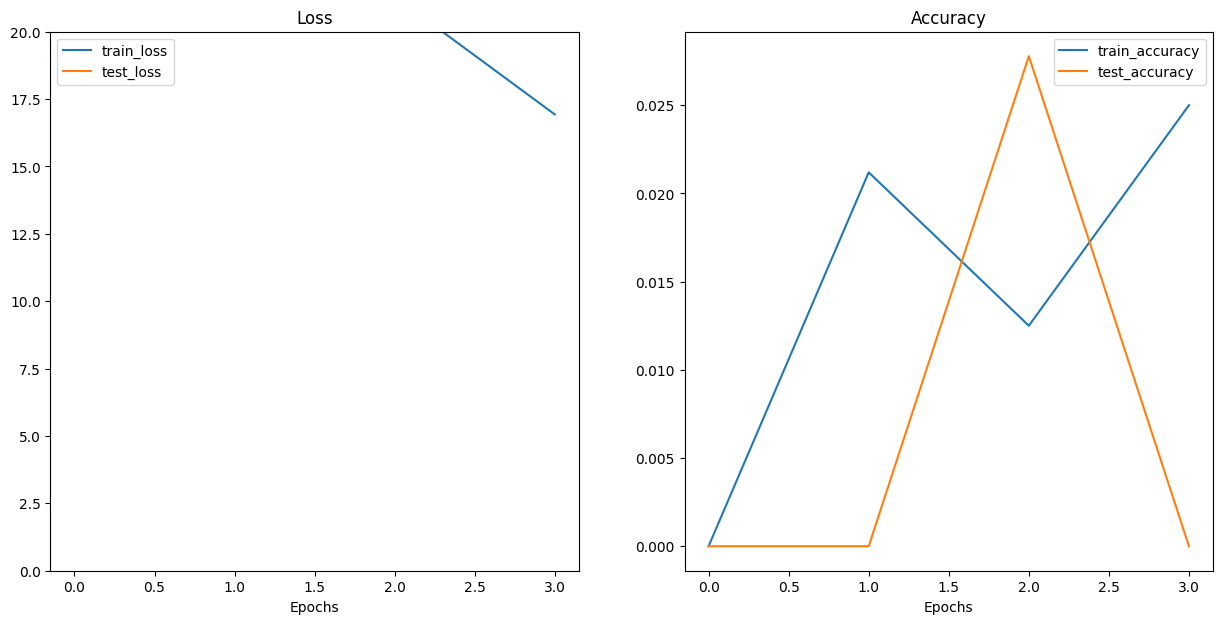

In [9]:
data=Data()
train_features_batch, train_labels_batch = next(iter(data.train_dataloader))
print(f"len train_dataloader {len(data.train_dataloader)*32}")
print(f"len test_dataloader {len(data.test_dataloader)*32}")



net=ResNet18(SimpleResNetblock,3,len(data.classes),[3,4,6,3])
x=torch.randn(2,3,224,224)
print(f"in shape {x.shape}")

y=net(x)
print(f"out shape {y.shape}")


net_optimizer=torch.optim.SGD(net.parameters(),lr=0.1)
net_loss_fn=nn.CrossEntropyLoss()
res=Totrain(net,data,net_optimizer,net_loss_fn,4)

plot_loss_curves(res)





In [14]:
class ResNetblock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,identity_downsample=None) -> None:
        super(ResNetblock,self).__init__()

        self.expansion=4

        self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=stride)
        self.bn1=nn.BatchNorm2d(out_channels)
       
        self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2=nn.BatchNorm2d(out_channels)
       
        self.conv3=nn.Conv2d(in_channels=out_channels,out_channels=out_channels*self.expansion,kernel_size=3,padding=1,stride=1)
        self.bn3=nn.BatchNorm2d(out_channels*self.expansion)
        
        
        self.relu=nn.ReLU()

        self.identity_downsample=identity_downsample
    
    def forward(self,x):
        identity=x
        # print(f"identity shape x{identity.shape}")
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)

        x=self.conv2(x)
        x=self.bn2(x)

        if self.identity_downsample != None:
            identity=self.identity_downsample(identity)
            # print(f"identity shape after {identity.shape}")
            # print(f"x shape {x.shape}")

        x+=identity
        x=self.relu(x)
        # print(f"x shape {x.shape}")

        return x


In [19]:
class ResNet50(nn.Module):
    def __init__(self,block:SimpleResNetblock,img_channels,num_classes,block_num:list) -> None:
        super(ResNet50,self).__init__()
        
        self.in_channels=64
        self.out_channels=64

        self.conv1=nn.Conv2d(img_channels,64,kernel_size=7,stride=2,padding=3)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        # self.layer2=self._make_layer(block,block_num[0],64,1)

        self.expansion=4

        self.layer1  =nn.Conv2d(in_channels=self.in_channels,out_channels=self.out_channels,kernel_size=3,padding=1,stride=1)
        self.bn1    =nn.BatchNorm2d(self.out_channels)
       
        self.in_channels=self.out_channels

        self.layer2  =nn.Conv2d(in_channels=self.in_channels,out_channels=self.out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2    =nn.BatchNorm2d(self.out_channels)
       


        self.layer3  =nn.Conv2d(in_channels=self.out_channels,out_channels=self.out_channels*self.expansion,kernel_size=3,padding=1,stride=1)
        self.bn3    =nn.BatchNorm2d(self.out_channels*self.expansion)
        self.in_channels=self.out_channels*self.expansion
        
        
        
            
        self.layer1_2  =nn.Conv2d(in_channels=self.in_channels,out_channels=self.out_channels,kernel_size=3,padding=1,stride=1)
        self.bn1_2    =nn.BatchNorm2d(self.out_channels)
       
        self.in_channels=self.out_channels

        self.layer2_2  =nn.Conv2d(in_channels=self.in_channels,out_channels=self.out_channels,kernel_size=3,padding=1,stride=1)
        self.bn2_2    =nn.BatchNorm2d(self.out_channels)
       


        self.layer3_2  =nn.Conv2d(in_channels=self.out_channels,out_channels=self.out_channels*self.expansion,kernel_size=3,padding=1,stride=1)
        self.bn3_2    =nn.BatchNorm2d(self.out_channels*self.expansion)

        self.in_channels=self.out_channels*self.expansion

        # self.avg=nn.AvgPool2d((1,1))
        # self.fc=nn.Linear(64*56*56,num_classes)


    def forward(self,x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        print(f"after maxpool shape {x.shape}")
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        print(f"after layer3 shape {x.shape}")
        
        x=self.layer1_2(x)
        print(f"after layer1_2 shape {x.shape}")
        x=self.layer2_2(x)
        x=self.layer3_2(x)
        
        # x=self.avg(x)
        # print(f"shape after avg {x.shape}")
        # x=x.reshape(x.shape[0],-1)
        # print(f"shape after reshape {x.shape}")
        # x=self.fc(x)
        # print(f"output shape {x.shape}")
        
        return x
    
    def _make_layer(self,block,num_blocks,out_channels,stride):
        identity_downsample=None
        layers=[]
        if stride!=1:
            identity_downsample=nn.Sequential(
                nn.Conv2d(self.in_channels,out_channels,1,stride,padding=0),
                nn.BatchNorm2d(out_channels)
            )
        layers.append(block(self.in_channels,out_channels=out_channels,stride=stride,identity_downsample=identity_downsample))
        self.in_channels=out_channels

        for i in range(num_blocks-1):
            layers.append(block(self.in_channels,out_channels=out_channels))

        return nn.Sequential(*layers)
    
    

In [20]:
x=torch.randn(2,3,224,224)

net50=ResNet50(ResNetblock,3,4,[1])

y=net50(x)

print(y.shape)



after maxpool shape torch.Size([2, 64, 56, 56])
after layer3 shape torch.Size([2, 256, 56, 56])
after layer1_2 shape torch.Size([2, 64, 56, 56])
torch.Size([2, 256, 56, 56])
